![](image.jpg)


Dive into the heart of data science with a project that combines healthcare insights and predictive analytics. As a Data Scientist at a top Health Insurance company, you have the opportunity to predict customer healthcare costs using the power of machine learning. Your insights will help tailor services and guide customers in planning their healthcare expenses more effectively.

## Dataset Summary

Meet your primary tool: the `insurance.csv` dataset. Packed with information on health insurance customers, this dataset is your key to unlocking patterns in healthcare costs. Here's what you need to know about the data you'll be working with:

## insurance.csv
| Column    | Data Type | Description                                                      |
|-----------|-----------|------------------------------------------------------------------|
| `age`       | int       | Age of the primary beneficiary.                                  |
| `sex`       | object    | Gender of the insurance contractor (male or female).             |
| `bmi`       | float     | Body mass index, a key indicator of body fat based on height and weight. |
| `children`  | int       | Number of dependents covered by the insurance plan.              |
| `smoker`    | object    | Indicates whether the beneficiary smokes (yes or no).            |
| `region`    | object    | The beneficiary's residential area in the US, divided into four regions. |
| `charges`   | float     | Individual medical costs billed by health insurance.             |



A bit of data cleaning is key to ensure the dataset is ready for modeling. Once your model is built using the `insurance.csv` dataset, the next step is to apply it to the `validation_dataset.csv`. This new dataset, similar to your training data minus the `charges` column, tests your model's accuracy and real-world utility by predicting costs for new customers.

## Let's Get Started!

This project is your playground for applying data science in a meaningful way, offering insights that have real-world applications. Ready to explore the data and uncover insights that could revolutionize healthcare planning? Let's begin this exciting journey!

Kindly note that I have created this notebook to be interactive and easy to follow by inserting comment inbetween the code

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# New section

In [ ]:
# Re-run this cell
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

# Loading the insurance dataset
insurance_data_path = 'insurance.csv'
insurance = pd.read_csv(insurance_data_path)
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19.0,female,27.900,0.0,yes,southwest,16884.924
1,18.0,male,33.770,1.0,no,Southeast,1725.5523
2,28.0,male,33.000,3.0,no,southeast,$4449.462
3,33.0,male,22.705,0.0,no,northwest,$21984.47061
4,32.0,male,28.880,0.0,no,northwest,$3866.8552


Checking some of the dataset attribute

In [ ]:
insurance.describe()

,age,bmi,children
count,1272.000000,1272.000000,1272.000000
mean,35.214623,30.560550,0.948899
std,22.478251,6.095573,1.303532
min,-64.000000,15.960000,-4.000000
25%,24.750000,26.180000,0.000000
50%,38.000000,30.210000,1.000000
75%,51.000000,34.485000,2.000000
max,64.000000,53.130000,5.000000


#Data Cleaning

the age and children variable have some -ve values that we will have do handle as part of the data cleaning process

In [ ]:
insurance['smoker'].value_counts()

no     1013
yes     259
Name: smoker, dtype: int64

In [ ]:
insurance[['region', 'smoker']].value_counts()

region     smoker
Southeast  no        132
southwest  no        131
Northwest  no        128
northwest  no        122
Northeast  no        120
southeast  no        120
northeast  no        119
Southwest  no        117
southeast  yes        43
Southeast  yes        38
Northeast  yes        31
northeast  yes        31
southwest  yes        30
Northwest  yes        27
northwest  yes        27
Southwest  yes        26
dtype: int64

The variable region has 4 labels, however, we need to clean the variable to have a uniform format

In [ ]:
insurance['sex'].value_counts()

male      517
female    503
man        64
M          64
woman      62
F          62
Name: sex, dtype: int64

Just like region, sex also need to clean into a uniform format

Defining a function to ensure consistency in the variable sex

In [ ]:
#this function converts 'man' and 'm' into 'male and 'woman' and 'f' into 'female'
def clean_sex(gender):
    if str(gender).lower() in ['man', 'm']:
        return 'male'
    elif str(gender).lower() in ['woman', 'f']:
        return 'female'
    else:
        return gender

insurance['sex'] = insurance['sex'].apply(clean_sex)

insurance['sex'].value_counts()

male      645
female    627
Name: sex, dtype: int64

Now that we have cleaned the variable 'sex' let us see the number of male and female that are smokers

In [ ]:
insurance[['sex', 'smoker']].value_counts()

sex     smoker
female  no        505
male    no        481
        yes       145
female  yes       107
dtype: int64

'charges' - the target variable have some inconsistency that need to be cleaned

In [ ]:
#removing the $ sign and roundinf to 2-decimals
insurance['charges'] = insurance['charges'].str.replace('$', '', regex=False).astype(float).round(2)

In [ ]:
insurance['children'].value_counts()

 0.0    551
 1.0    292
 2.0    209
 3.0    140
-1.0     20
 4.0     20
 5.0     16
-2.0     12
-3.0      9
-4.0      3
Name: children, dtype: int64

children are number of dependents covered by the plan, hence the values should not be -ve.
Some values in age are also -ve.

Lets explore if the -ves in age and children co-occur

In [ ]:
neg_val = insurance[(insurance['age'] < 0) | (insurance['children'] < 0)]
neg_val

,age,sex,bmi,children,smoker,region,charges
5,-31.0,female,25.740,0.0,no,southeast,3756.62
14,-27.0,male,42.130,0.0,yes,southeast,39611.76
17,-23.0,male,23.845,0.0,no,northeast,2395.17
23,-34.0,female,NaN,1.0,yes,NaN,37701.88
34,28.0,male,36.400,-1.0,yes,Southwest,51194.56
...,...,...,...,...,...,...,...
1291,-19.0,male,34.900,0.0,yes,southwest,34828.65
1299,19.0,female,25.745,-1.0,no,northwest,2710.83
1303,-43.0,male,27.800,0.0,yes,southwest,37829.72
1311,-33.0,female,26.695,0.0,no,northwest,4571.41


There are no co-occurence in the -ve values of 'age' and 'children'
I will analyze the correlation amoung the non -ve values, if the correlation is strong, then I can use KNN for data imputation.

In [ ]:
df = insurance[(insurance['age'] >= 0) & (insurance['children'] >= 0)]
#df

In [ ]:
df.isna().sum()
df.dropna(inplace=True)

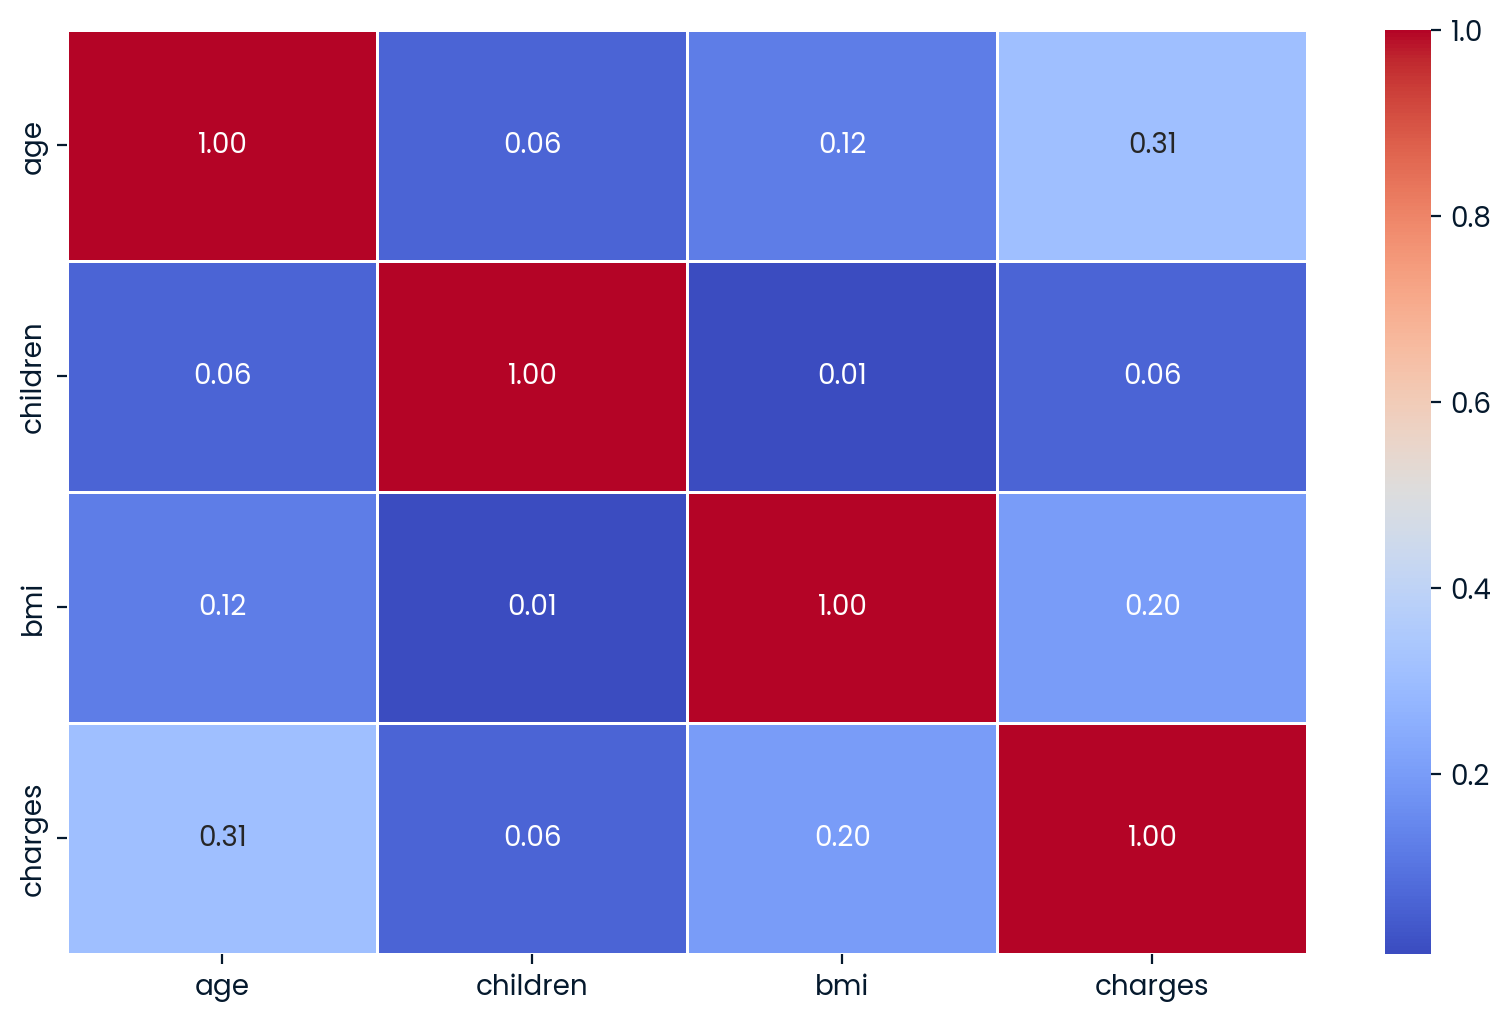

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

df2 = df[['age', 'children', 'bmi', 'charges']]
df_corr = df2.corr()

plt.figure(figsize=(10,6))
sns.heatmap(df_corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.show()

Only age and charges have a moderate correlation, others are weak.
KNN may not be the best option.

I will treat each variable separately

In [ ]:
insurance['age'] = insurance['age'].apply(lambda x: np.nan if x <= 0 else x) # where age is <= 0 replace with nan to be drop later
insurance['children'] = insurance['children'].apply(lambda x: 0 if x < 0 else x) # where children is < 0 (i.e negative) repalce with 0
insurance['charges'] = insurance['charges'].apply(lambda x: 1000 if pd.isna(x) else x) #where charge in the target variable is nan replace with 1000, the minimum allowed charge

In [ ]:
insurance['bmi'].fillna(insurance['bmi'].median(), inplace=True) #repalce nan values in bmi with median
insurance = insurance.dropna(subset=['age']) #drop nan rows in 'age' alongside corresponding rows in other variables

# impute missing values with mode for categorical columns
insurance['sex'].fillna(insurance['sex'].mode()[0], inplace=True)
insurance['smoker'].fillna(insurance['smoker'].mode()[0], inplace=True)
#insurance['region'].fillna(insurance['region'].mode()[0], inplace=True)

In [ ]:
def clean_region(region):
    if str(region).lower() in ['southeast']:
        return 'southeast'
    elif str(region).lower() in ['southwest']:
        return 'southwest'
    elif str(region).lower() in ['northwest']:
        return 'northwest'
    elif str(region).lower() in ['northeast']:
        return 'northeast'
    else:
        return region

insurance['region'] = insurance['region'].apply(clean_region)

insurance['region'].fillna(insurance['region'].mode()[0], inplace=True)

In [ ]:
insurance.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1207 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1207 non-null   float64
 1   sex       1207 non-null   object 
 2   bmi       1207 non-null   float64
 3   children  1178 non-null   float64
 4   smoker    1207 non-null   object 
 5   region    1207 non-null   object 
 6   charges   1207 non-null   float64
dtypes: float64(4), object(3)
memory usage: 75.4+ KB


## I now have a clean data that can be used in a machine learning algorithm

In [ ]:
#insurance['children'] = insurance['children'].astype(str)

#Feature Engineering

In [ ]:
#Encoding the categorical features
df_cat = pd.get_dummies(insurance, columns=['sex', 'smoker', 'region'], drop_first=True)
df_cat

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19.0,27.900,0.0,16884.92,0,1,0,0,1
1,18.0,33.770,1.0,1725.55,1,0,0,1,0
2,28.0,33.000,3.0,4449.46,1,0,0,1,0
3,33.0,22.705,0.0,21984.47,1,0,1,0,0
4,32.0,28.880,0.0,3866.86,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...
1332,52.0,44.700,3.0,11411.68,0,0,0,0,1
1333,50.0,30.970,3.0,10600.55,1,0,1,0,0
1335,18.0,36.850,0.0,1629.83,0,0,0,1,0
1336,21.0,25.800,0.0,2007.94,0,0,0,0,1


I have encoded the categorical variable above.

Next, I will apply some data transformation method such equal-frequency binning to create a representation of some variables.



1.   I am creating an age group for the age variable by creating bins in the age bracket 0-18, 19-35, 36-50, 51-100 corresponding to 'Child', 'Young Adult', 'Middle-Aged', 'Senior'
2.   Using domain information on bmi that could be obtained online, I am categorizing the bmi into 4 standard categorise based on the bmi values ('Underweight', 'Normal', 'Overweight', 'Obese')

This engineered features will be additional input into the model I will create



In [ ]:
#I will apply binning method on the continous variables

#age
df_cat['age_group'] = pd.cut(df_cat['age'], bins=[0, 18, 35, 50, 100], labels=['Child', 'Young Adult', 'Middle-Aged', 'Senior'])

#bmi
df_cat['bmi_category'] = pd.cut(df_cat['bmi'], bins=[0, 18.5, 24.9, 29.9, 100], labels=['Underweight', 'Normal', 'Overweight', 'Obese'])
df_cat.head()

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest,age_group,bmi_category
0,19.0,27.900,0.0,16884.92,0,1,0,0,1,Young Adult,Overweight
1,18.0,33.770,1.0,1725.55,1,0,0,1,0,Child,Obese
2,28.0,33.000,3.0,4449.46,1,0,0,1,0,Young Adult,Obese
3,33.0,22.705,0.0,21984.47,1,0,1,0,0,Young Adult,Normal
4,32.0,28.880,0.0,3866.86,1,0,1,0,0,Young Adult,Overweight


Now, I will use visualization to explore if there are relationship between the created age-group and insurance charges and also between charges and smokers

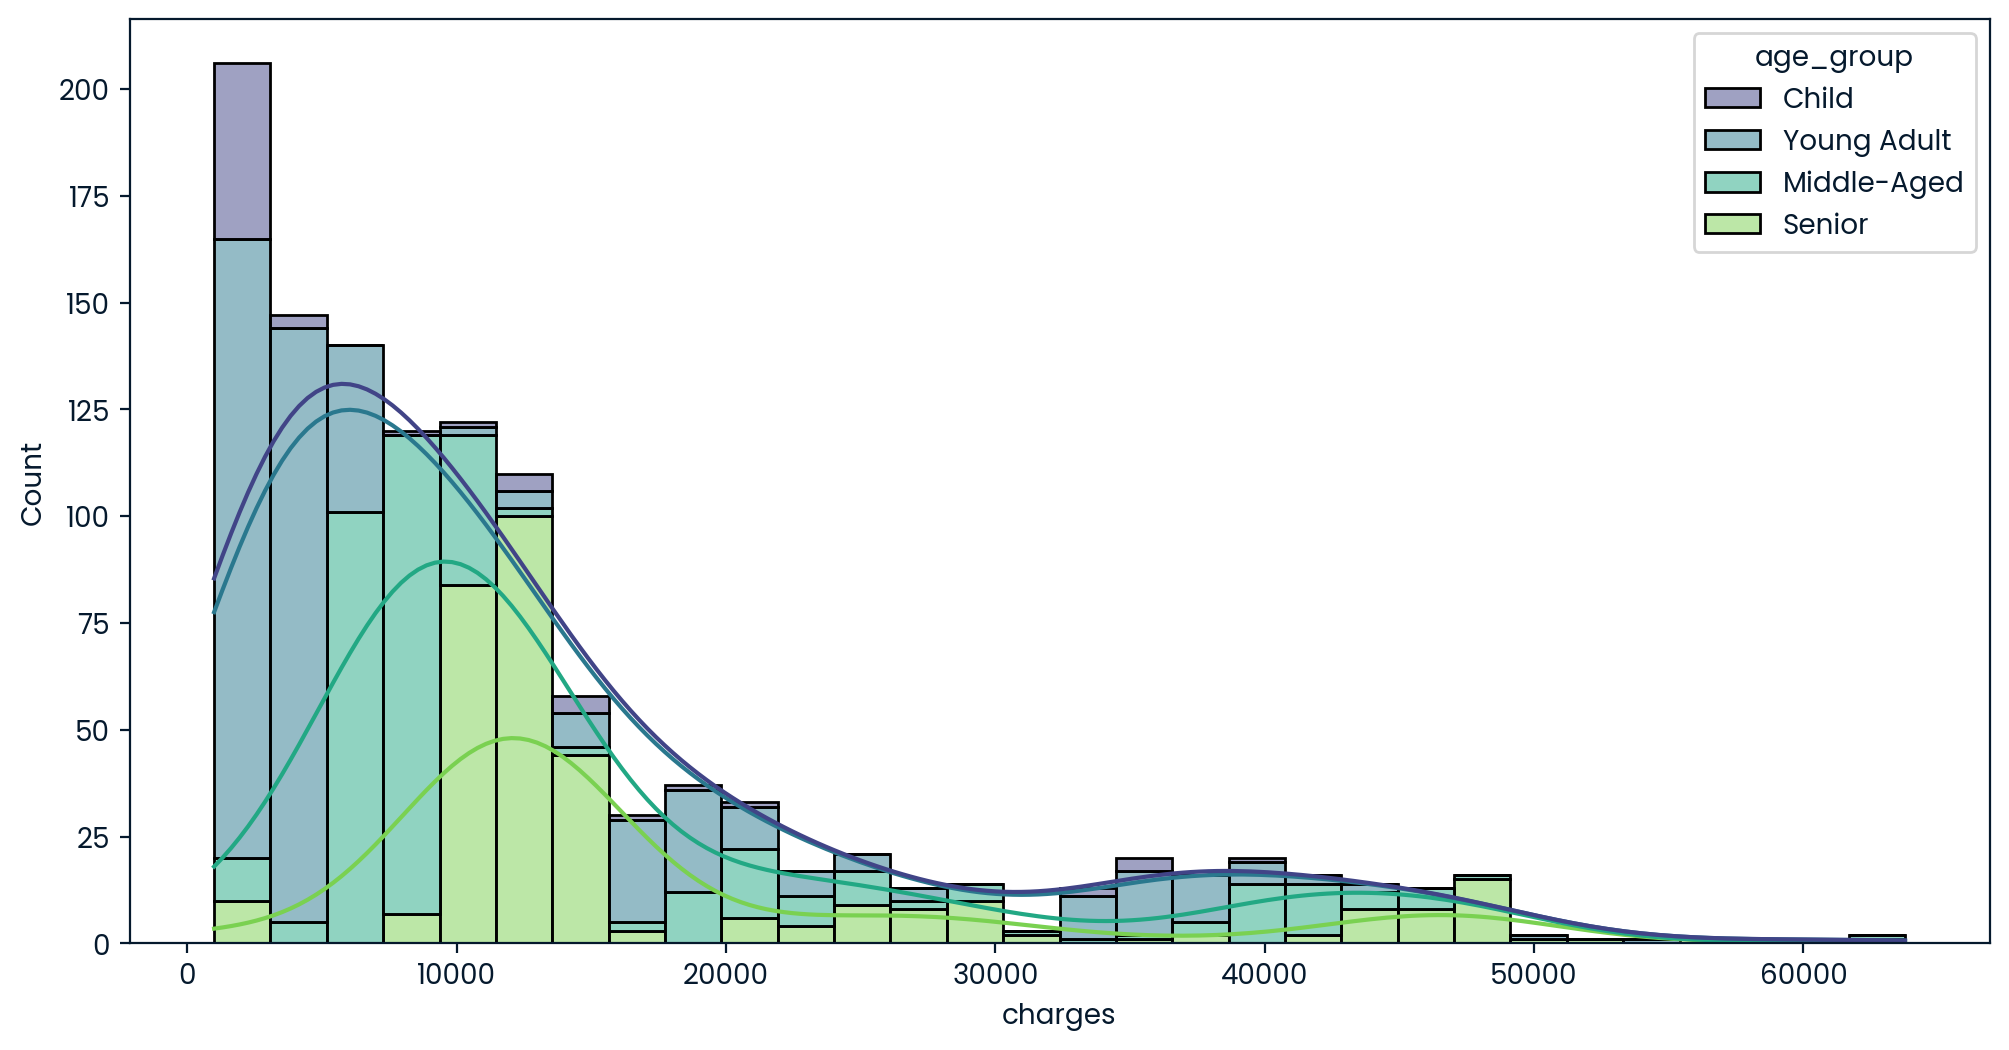

In [ ]:
#charges and age-group
plt.figure(figsize=(12, 6))
sns.histplot(data=df_cat, x='charges', hue='age_group', kde=True, palette='viridis', multiple='stack')
plt.show()


The above visualization shows distribution of the age-groups based on the insurance charges paid.
The plot is skewed to the right, with some young_adult and middle_aged paying very high premium. The relationship between the 2 variable is not linear


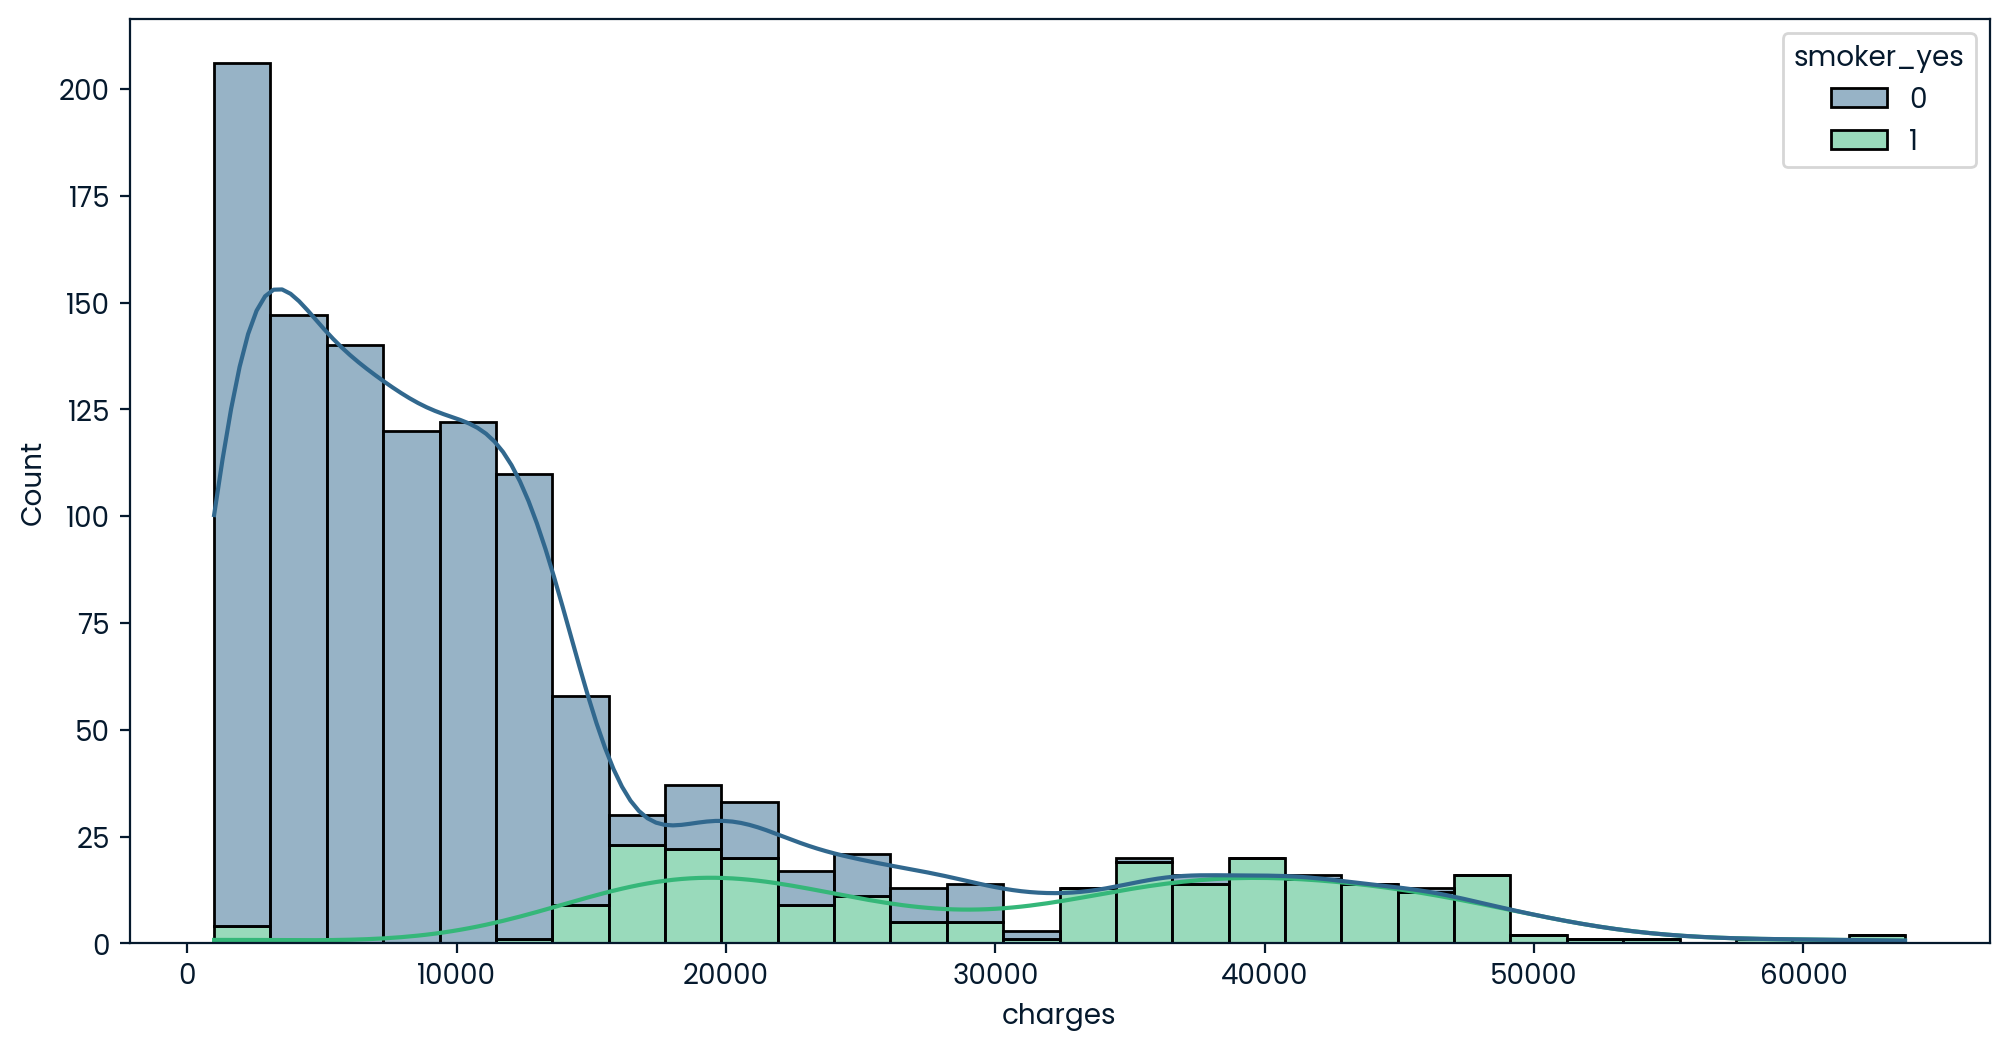

In [ ]:
#charges and smokers
plt.figure(figsize=(12, 6))
sns.histplot(data=df_cat, x='charges', hue='smoker_yes', kde=True, palette='viridis', multiple='stack')
plt.show()

This plot shows that smokers pay higher insurance premium.

Therefore to capture the risk associated with smoking leading to higher charges, we will create another feature by multiplying age with smoker_yes

In [ ]:
df_cat['age_smoker_risk'] = df_cat['age'] * df_cat['smoker_yes']
df_cat.head()

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest,age_group,bmi_category,age_smoker_risk
0,19.0,27.900,0.0,16884.92,0,1,0,0,1,Young Adult,Overweight,19.0
1,18.0,33.770,1.0,1725.55,1,0,0,1,0,Child,Obese,0.0
2,28.0,33.000,3.0,4449.46,1,0,0,1,0,Young Adult,Obese,0.0
3,33.0,22.705,0.0,21984.47,1,0,1,0,0,Young Adult,Normal,0.0
4,32.0,28.880,0.0,3866.86,1,0,1,0,0,Young Adult,Overweight,0.0


I have engineered 3 additional features (age_group, bmi_category, and age_smoker_risk)

In [ ]:
#One-hot encoding age_group and bmi_category

df_cat2 = pd.get_dummies(df_cat, columns=['age_group', 'bmi_category'], drop_first=True)
df_cat2.head()

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest,age_smoker_risk,age_group_Young Adult,age_group_Middle-Aged,age_group_Senior,bmi_category_Normal,bmi_category_Overweight,bmi_category_Obese
0,19.0,27.900,0.0,16884.92,0,1,0,0,1,19.0,1,0,0,0,1,0
1,18.0,33.770,1.0,1725.55,1,0,0,1,0,0.0,0,0,0,0,0,1
2,28.0,33.000,3.0,4449.46,1,0,0,1,0,0.0,1,0,0,0,0,1
3,33.0,22.705,0.0,21984.47,1,0,1,0,0,0.0,1,0,0,1,0,0
4,32.0,28.880,0.0,3866.86,1,0,1,0,0,0.0,1,0,0,0,1,0


In [ ]:
# Scaling the contineous variables

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_cat2[['age', 'bmi', 'age_smoker_risk', 'children']] = scaler.fit_transform(df_cat2[['age', 'bmi', 'age_smoker_risk', 'children']])
df_cat2.head()

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest,age_smoker_risk,age_group_Young Adult,age_group_Middle-Aged,age_group_Senior,bmi_category_Normal,bmi_category_Overweight,bmi_category_Obese
0,-1.433245,-0.444099,-0.855246,16884.92,0,1,0,0,1,0.691919,1,0,0,0,1,0
1,-1.503909,0.524921,-0.014278,1725.55,1,0,0,1,0,-0.462521,0,0,0,0,0,1
2,-0.797268,0.397809,1.667658,4449.46,1,0,0,1,0,-0.462521,1,0,0,0,0,1
3,-0.443948,-1.301690,-0.855246,21984.47,1,0,1,0,0,-0.462521,1,0,0,1,0,0
4,-0.514612,-0.282320,-0.855246,3866.86,1,0,1,0,0,-0.462521,1,0,0,0,1,0


In [ ]:
df_cat2.shape

(1207, 16)

In [ ]:
y= df_cat2['charges']
x = df_cat2.drop(columns=['charges'])

In [ ]:
print(x.shape)
print(y.shape)

(1207, 15)
(1207,)


Building the Model

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

#initialize the XGBoost Regressor
xgboost_model = XGBRegressor(
    n_estimators=50,
    learning_rate=0.06,
    max_depth=3,
    subsample=0.5,
    colsample_bytree=0.5,
    random_state=42,
    min_child_weight= 10,
    gamma = 0.1
)

#5-fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

cv_scores = cross_val_score(xgboost_model, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')
cv_r2_scores = cross_val_score(xgboost_model, X_train, y_train, cv=kf, scoring='r2')

xgboost_model.fit(X_train, y_train)

y_pred = xgboost_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Cross-Validated Mean Squared Error: {-np.mean(cv_scores):.2f}")
print(f"Cross-Validated R-squared Score: {np.mean(cv_r2_scores):.2f}")
print(f"Test Set Mean Squared Error: {mse:.2f}")
print(f"Test Set R-squared Score: {r2:.2f}")


Cross-Validated Mean Squared Error: 27434916.16
Cross-Validated R-squared Score: 0.82
Test Set Mean Squared Error: 41026679.90
Test Set R-squared Score: 0.70


Using R-Square as the evaluation metric

R-square on the training set = 0.82

R-square on the test set = 0.70

Note: The hyperparameters used in this model where arrived at using Random Search method. I will advice using a Bayesian Optimization to search for hyperparameters around the values from the Random Search method

The feature importance shows that the engineered features are very important to the model's performance

<Figure size 1200x800 with 0 Axes>

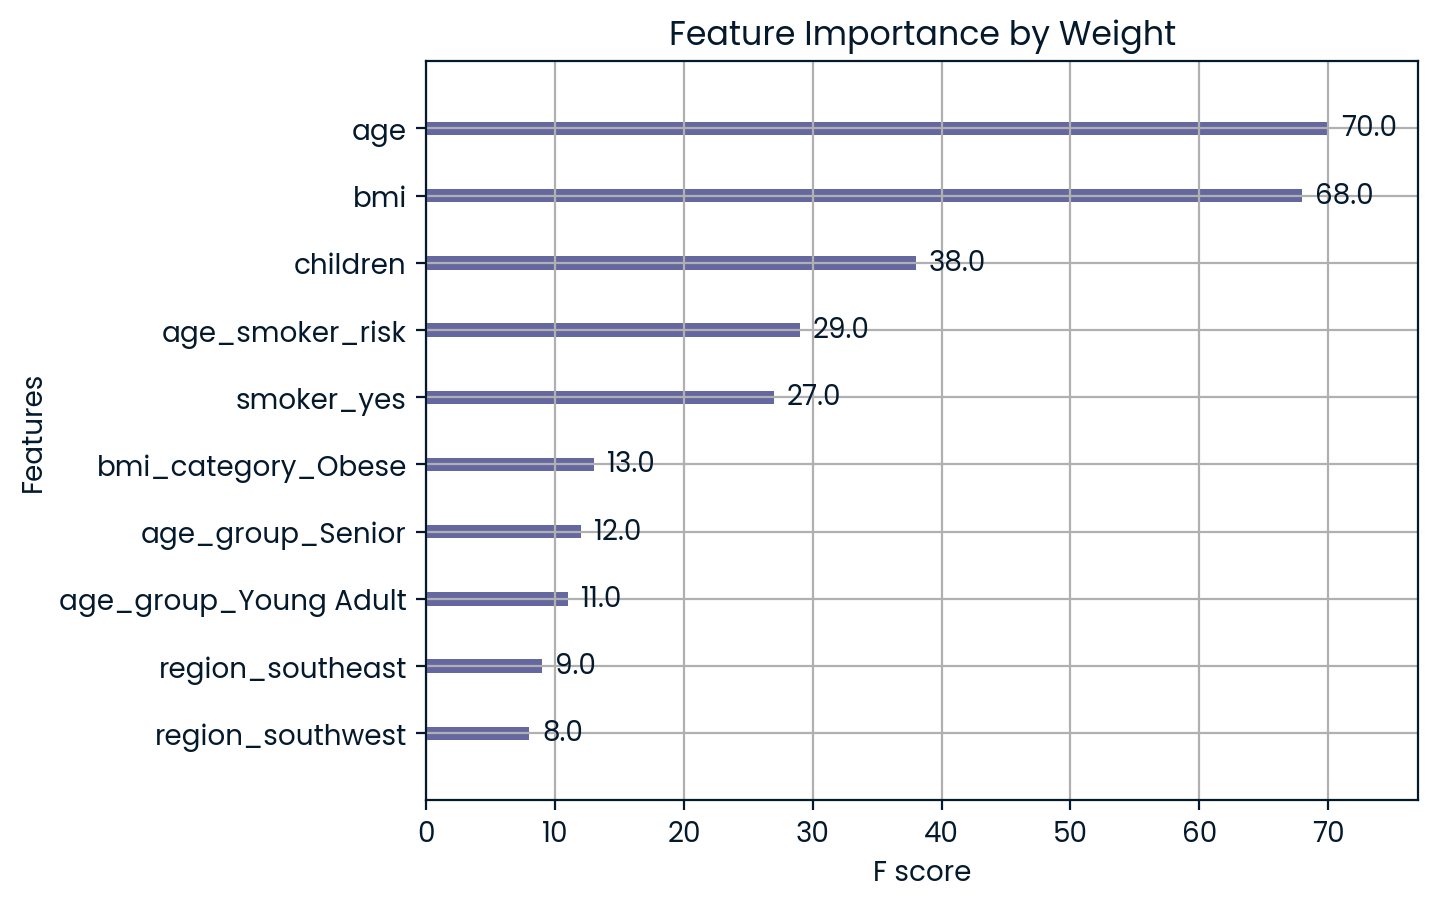

In [ ]:
from xgboost import XGBRegressor, plot_importance

plt.figure(figsize=(12, 8))
plot_importance(xgboost_model, importance_type='weight', max_num_features=10, title='Feature Importance by Weight')
plt.show()

In [ ]:
importance_df = pd.DataFrame({
    'Feature': x.columns,
    'Importance': xgboost_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(importance_df)

                    Feature  Importance
4                smoker_yes    0.452682
8           age_smoker_risk    0.214634
13  bmi_category_Overweight    0.072050
1                       bmi    0.053160
11         age_group_Senior    0.052550
14       bmi_category_Obese    0.042729
12      bmi_category_Normal    0.030235
0                       age    0.026951
9     age_group_Young Adult    0.014707
10    age_group_Middle-Aged    0.013874
2                  children    0.008808
7          region_southwest    0.007384
5          region_northwest    0.004353
3                  sex_male    0.003060
6          region_southeast    0.002822


In [ ]:
validation_data_path = 'validation_dataset.csv'
val = pd.read_csv(validation_data_path)
val.head()

,Unnamed: 0,age,bmi,children,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest,age_group_Young Adult,age_group_Middle-Aged,age_group_Senior,bmi_category_Normal,bmi_category_Overweight,bmi_category_Obese,age_smoker_risk
0,0,-1.342765,-0.880452,-0.446515,0,0,0,1,0,0,0,0,1,0,0,-0.654251
1,1,-0.364345,-0.748241,-0.697366,1,1,0,0,0,0,1,0,0,1,0,0.615191
2,2,-0.923442,-0.592095,-0.697366,1,1,0,1,0,1,0,0,0,1,0,0.224594
3,3,1.126581,1.479524,2.563699,1,1,0,1,0,0,0,1,0,0,1,1.656786
4,4,-0.876851,-0.084336,-0.697366,1,0,0,1,0,1,0,0,0,0,1,-0.654251



#Putting it all together

In [ ]:
def clean_region(region):
    if str(region).lower() in ['southeast']:
        return 'southeast'
    elif str(region).lower() in ['southwest']:
        return 'southwest'
    elif str(region).lower() in ['northwest']:
        return 'northwest'
    elif str(region).lower() in ['northeast']:
        return 'northeast'
    else:
        return region

def clean_sex(gender):
    if str(gender).lower() in ['man', 'm']:
        return 'male'
    elif str(gender).lower() in ['woman', 'f']:
        return 'female'
    else:
        return gender

def preprocess_data(df):

    # Clean the data
    df['sex'] = df['sex'].apply(clean_sex)
    df['region'] = df['region'].apply(clean_region)
    #df['charges'] = df['charges'].str.replace('$', '', regex=False).astype(float).round(2)
    df['children'] = df['children'].apply(lambda x: 0 if x < 0 else x)

    if 'charges' in df.columns:
        df['charges'] = df['charges'].str.replace('$', '', regex=False).astype(float).round(2)
        df['charges'] = df['charges'].apply(lambda x: 1000 if pd.isna(x) else x)

    df['age'] = df['age'].apply(lambda x: np.nan if x <= 0 else x)
    df = df.dropna(subset=['age'])

    df['bmi'].fillna(df['bmi'].median(), inplace=True)
    #df['charges'].fillna(df['charges'].median(), inplace=True)


    # impute missing values with mode for categorical columns
    df['sex'].fillna(df['sex'].mode()[0], inplace=True)
    df['smoker'].fillna(df['smoker'].mode()[0], inplace=True)
    df['region'].fillna(df['region'].mode()[0], inplace=True)

    # Feature Engineering
    df['age_group'] = pd.cut(df['age'], bins=[0, 18, 35, 50, 100], labels=['Child', 'Young Adult', 'Middle-Aged', 'Senior'])
    df['bmi_category'] = pd.cut(df['bmi'], bins=[0, 18.5, 24.9, 29.9, 100], labels=['Underweight', 'Normal', 'Overweight', 'Obese'])
    #df['age_smoker_risk'] = df['age'] * df['smoker_yes']
    #df['children'] = df['children'].astype(str)
    df = pd.get_dummies(df, columns=['sex', 'smoker', 'region', 'age_group', 'bmi_category'], drop_first=True)
    df['age_smoker_risk'] = df['age'] * df['smoker_yes']

    # Scaling numerical features
    scaler = StandardScaler()
    numerical_features = ['age', 'bmi', 'age_smoker_risk', 'children']
    df[numerical_features] = scaler.fit_transform(df[numerical_features])

    return df

In [ ]:
def train_xgboost_model(X, y):
    xgboost_model = XGBRegressor(
        n_estimators=50,
        learning_rate=0.06,
        max_depth=3,
        subsample=0.5,
        colsample_bytree=0.5,
        random_state=42
    )
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(xgboost_model, X, y, cv=kf, scoring='neg_mean_squared_error')
    cv_r2_scores = cross_val_score(xgboost_model, X, y, cv=kf, scoring='r2')

    xgboost_model.fit(X, y)

    print(f"Cross-Validated Mean Squared Error: {-np.mean(cv_scores):.2f}")
    print(f"Cross-Validated R-squared Score: {np.mean(cv_r2_scores):.2f}")

    return xgboost_model


In [ ]:
preds = []
def evaluate_model(model, validation_path):
    validation_data = pd.read_csv(validation_path, index_col=0)
    #validation_data = preprocess_data(validation_data)
    X_val = validation_data
    pred = model.predict(X_val)
    print("Predicted Charges:", pred)
    preds.extend(pred)

In [ ]:
training_data = pd.read_csv('insurance.csv')
training_data = preprocess_data(training_data)
training_data.shape

(1207, 16)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

training_data = pd.read_csv('insurance.csv')
training_data = preprocess_data(training_data)

X = training_data.drop(columns=['charges'])
y = training_data['charges']

xgboost_model = train_xgboost_model(X, y)

evaluate_model(xgboost_model, 'validation_dataset.csv')
validation_data = pd.read_csv('validation_dataset.csv')
validation_data['predicted_charges'] = preds

Cross-Validated Mean Squared Error: 28692446.36
Cross-Validated R-squared Score: 0.80
Predicted Charges: [ 4771.148  17378.047  16313.741  42865.363   4716.9    43002.664
  6098.2524  7195.1216  7443.0547 11721.802   5393.4976 10377.509
 11171.792  11026.787   4254.733   5810.5137 14897.91   44732.305
 41722.22   11237.249   4683.214   8114.4175 24408.434   7103.19
  7915.566   4055.0557 42566.004   4513.106  11907.593   7095.199
  5128.2104 19212.447  17919.227  11375.548  18127.264   8051.679
 42768.598   8922.016   4997.627  14150.429  24332.844   5845.3354
  4598.2974 43211.61    5089.614  30127.207  43929.74   23769.021
 10795.006  29010.54  ]


In [ ]:
val_data = pd.read_csv('validation_dataset.csv', index_col=0)
training_data = preprocess_data(training_data)
#val_data = val_data.drop(['Unnamed: 0'], axis=1)
#val_data.to_csv('validation_dataset.csv')
val_data

,age,bmi,children,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest,age_group_Young Adult,age_group_Middle-Aged,age_group_Senior,bmi_category_Normal,bmi_category_Overweight,bmi_category_Obese,age_smoker_risk
0,-1.342765,-0.880452,-0.446515,0,0,0,1,0,0,0,0,1,0,0,-0.654251
1,-0.364345,-0.748241,-0.697366,1,1,0,0,0,0,1,0,0,1,0,0.615191
2,-0.923442,-0.592095,-0.697366,1,1,0,1,0,1,0,0,0,1,0,0.224594
3,1.126581,1.479524,2.563699,1,1,0,1,0,0,0,1,0,0,1,1.656786
4,-0.876851,-0.084336,-0.697366,1,0,0,1,0,1,0,0,0,0,1,-0.654251
5,1.079990,1.904435,2.061997,0,1,0,1,0,0,0,1,0,0,1,1.624236
6,-0.830260,-0.423412,-0.195664,0,0,1,0,0,1,0,0,0,0,1,-0.654251
7,-0.224571,0.101728,-0.446515,0,0,0,0,0,0,1,0,0,0,1,-0.654251
8,0.054978,-0.168963,-0.697366,0,0,1,0,0,0,1,0,0,0,1,-0.654251
9,0.753850,-0.335082,0.055187,1,0,0,1,0,0,0,1,0,0,1,-0.654251


In [ ]:
validation_data

,Unnamed: 0,age,bmi,children,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest,age_group_Young Adult,age_group_Middle-Aged,age_group_Senior,bmi_category_Normal,bmi_category_Overweight,bmi_category_Obese,age_smoker_risk,predicted_charges
0,0,-1.342765,-0.880452,-0.446515,0,0,0,1,0,0,0,0,1,0,0,-0.654251,4771.147949
1,1,-0.364345,-0.748241,-0.697366,1,1,0,0,0,0,1,0,0,1,0,0.615191,17378.046875
2,2,-0.923442,-0.592095,-0.697366,1,1,0,1,0,1,0,0,0,1,0,0.224594,16313.741211
3,3,1.126581,1.479524,2.563699,1,1,0,1,0,0,0,1,0,0,1,1.656786,42865.363281
4,4,-0.876851,-0.084336,-0.697366,1,0,0,1,0,1,0,0,0,0,1,-0.654251,4716.899902
5,5,1.079990,1.904435,2.061997,0,1,0,1,0,0,0,1,0,0,1,1.624236,43002.664062
6,6,-0.830260,-0.423412,-0.195664,0,0,1,0,0,1,0,0,0,0,1,-0.654251,6098.252441
7,7,-0.224571,0.101728,-0.446515,0,0,0,0,0,0,1,0,0,0,1,-0.654251,7195.121582
8,8,0.054978,-0.168963,-0.697366,0,0,1,0,0,0,1,0,0,0,1,-0.654251,7443.054688
9,9,0.753850,-0.335082,0.055187,1,0,0,1,0,0,0,1,0,0,1,-0.654251,11721.801758
